In [ ]:
# L 4-23-25
# notebooks/3.2_CNN_Spectrogram_Classifier.ipynb

Using device: cpu
Epoch 1/5, Loss: 1.8256
Epoch 2/5, Loss: 1.5960
Epoch 3/5, Loss: 1.5271
Epoch 4/5, Loss: 1.4737
Epoch 5/5, Loss: 1.4176
Saved model weights to ../models/cnn_model.pth
Saved inference bundle to ../models/cnn_inference_bundle.pth
               precision    recall  f1-score   support

   Electronic       0.43      0.61      0.50       185
 Experimental       0.36      0.23      0.28       196
         Folk       0.55      0.60      0.57       197
      Hip-Hop       0.60      0.71      0.65       207
 Instrumental       0.43      0.52      0.47       180
International       0.47      0.49      0.48       198
          Pop       0.34      0.06      0.10       215
         Rock       0.53      0.69      0.60       221

     accuracy                           0.49      1599
    macro avg       0.46      0.49      0.46      1599
 weighted avg       0.47      0.49      0.46      1599



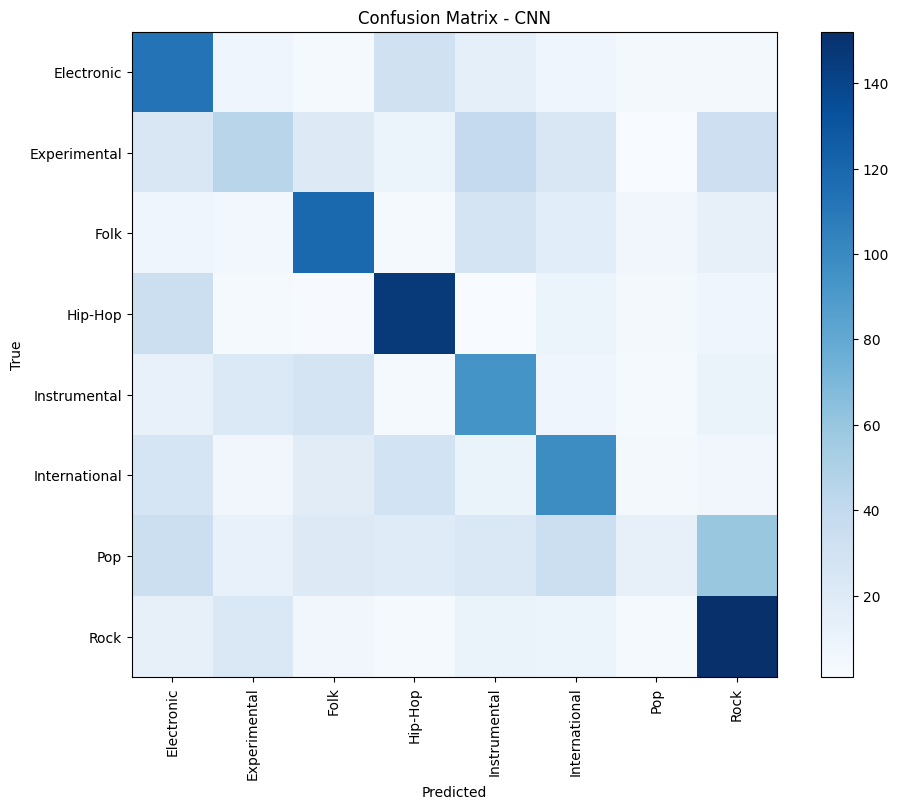

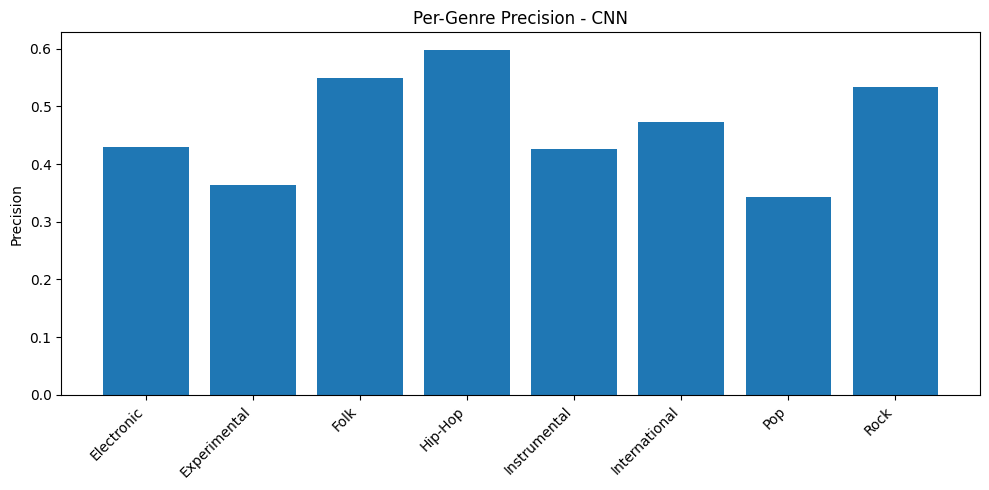

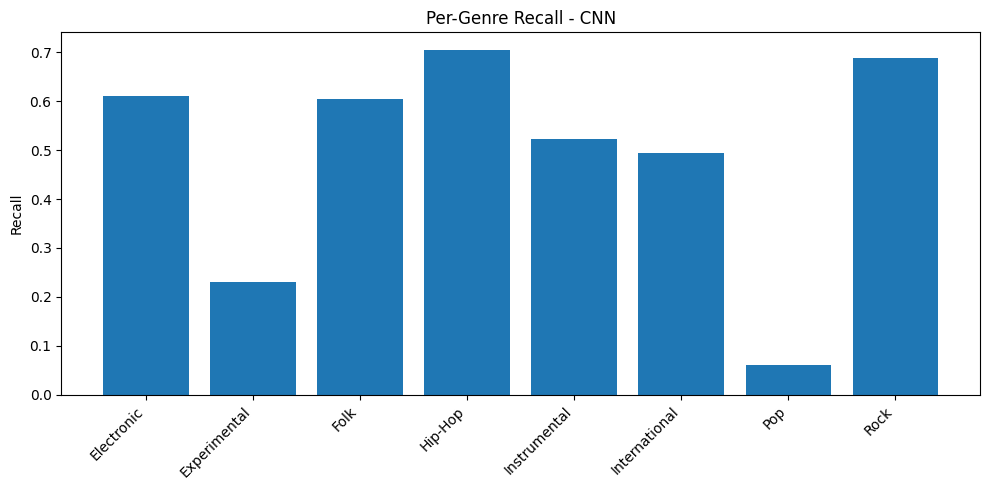

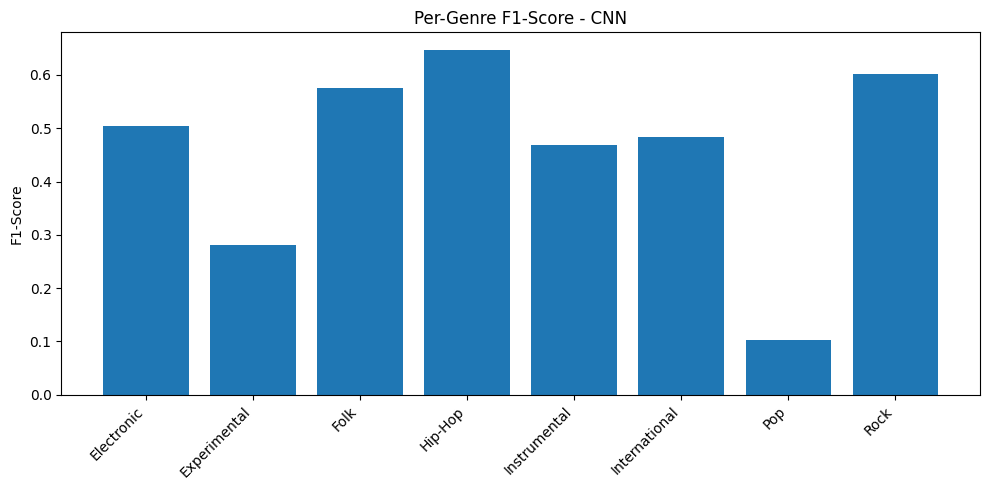

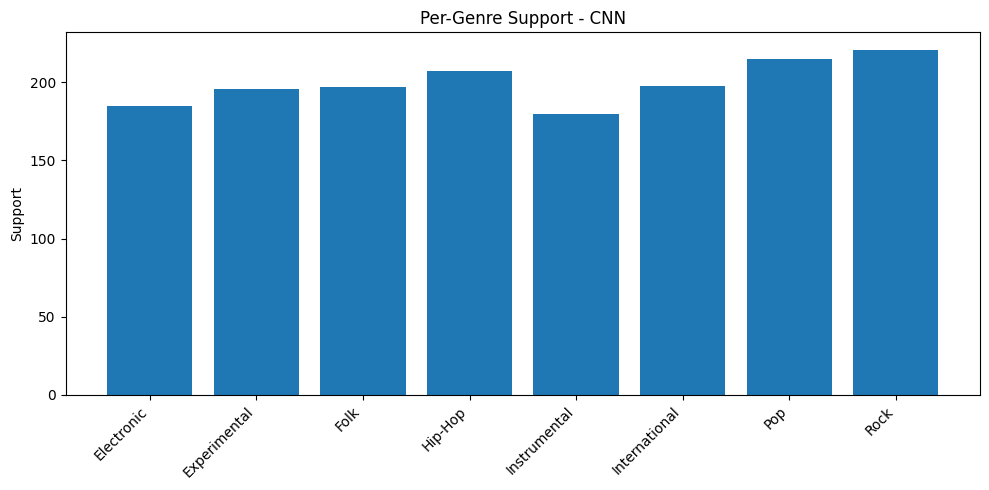

In [ ]:
# notebooks/3.2_CNN_Spectrogram_Classifier.ipynb

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Parameters
DATA_DIR = "../spectrograms"
BATCH_SIZE = 32
IMG_SIZE = 128
EPOCHS = 5
MODEL_SAVE_PATH = "../models/cnn_model.pth"
INFERENCE_BUNDLE_PATH = "../models/cnn_inference_bundle.pth"
REPORT_DIR = "../reports/3_CNN_Spectrogram_Classifier"
os.makedirs(REPORT_DIR, exist_ok=True)

# Data transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # for RGB
])

# Dataset and loader
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
class_names = dataset.classes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define CNN


class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Initialize model
model = SimpleCNN(num_classes=len(class_names)).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_losses = []
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

# Save model weights only
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Saved model weights to {MODEL_SAVE_PATH}")

# Save full inference bundle
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'transform': transform,
    'img_size': IMG_SIZE,
}, INFERENCE_BUNDLE_PATH)
print(f"Saved inference bundle to {INFERENCE_BUNDLE_PATH}")

# Evaluation
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)
with open(os.path.join(REPORT_DIR, "cnn_classification_report.txt"), "w") as f:
    f.write(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix - CNN")
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=90)
plt.yticks(np.arange(len(class_names)), class_names)
plt.tight_layout()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(os.path.join(REPORT_DIR, "cnn_confusion_matrix.png"))
plt.show()

# Per-genre performance metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=range(len(class_names)), zero_division=0)

metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}

for metric_name, values in metrics.items():
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, values)
    plt.ylabel(metric_name)
    plt.title(f"Per-Genre {metric_name} - CNN")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    filename = f"cnn_per_genre_{metric_name.lower().replace('-', '_')}.png"
    plt.savefig(os.path.join(REPORT_DIR, filename))
    plt.show()